In [1]:
import os

os.chdir("../..")
os.environ["CUDA_VISIBLE_DEVICES"] = "6"

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from collections import defaultdict

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm.notebook as tqdm

from modular_splicing.motif_names import get_motif_names
from modular_splicing.eclip.test_motifs.baseline import fm_baseline_nonbinarized
from modular_splicing.fit_rbns.load_rbns_neural import load_rbns_models_for_evaluation
from modular_splicing.fit_rbns.test_on_rbns import RBNSEvaluator
from modular_splicing.utils.plots.results_by_model_group import plot_by_model_group
from modular_splicing.models_for_testing.list import AM, FM

In [4]:
amount = 1000

In [5]:
fm_model_non_binarized = {}
am_models = {}
rbnsp_names = {}

In [6]:
def trained_e2e():
    ams = AM.binarized_models()
    fm_model_full = FM.non_binarized_model(1, density_override=0.75).model
    rbnsp_names_full = get_motif_names("rbns")
    fm_model_non_binarized.update({mod.name: fm_model_full for mod in ams})
    am_models.update({mod.name: mod.model for mod in ams})
    rbnsp_names.update({mod.name: rbnsp_names_full for mod in ams})

In [7]:
def add_models_generic(motifs_source, models):
    motif_names = get_motif_names(motifs_source)
    fm_model = fm_baseline_nonbinarized(motifs_source)
    fm_model_non_binarized.update({name: fm_model for name in models})
    am_models.update(models)
    rbnsp_names.update({name: motif_names for name in models})

In [8]:
def trained_on_rbns():
    loaded = load_rbns_models_for_evaluation(just_nfm=False)
    add_models_generic("rbns", models=loaded)

In [9]:
trained_e2e()
trained_on_rbns()

In [10]:
evaluators = {
    is_test: RBNSEvaluator(
        fm_model_non_binarized=fm_model_non_binarized,
        am_models=am_models,
        genome_calibration_amount=800,
        rbnsp_names=rbnsp_names,
        is_test=is_test,
    )
    for is_test in [True]
}

In [11]:
all_model_names = list(am_models)

In [12]:
results_each = {
    k: {
        model_name: evaluators[k].calculate_statistics_for_all_motifs(model_name)
        for model_name in tqdm.tqdm(all_model_names)
    }
    for k in evaluators
}

In [13]:
summarys_each = {
    k: pd.DataFrame(
        {name: pd.DataFrame(results_each[k][name]).T.mean() for name in all_model_names}
    ).T
    for k in results_each
}

In [14]:
outs_each = {
    k: pd.DataFrame(
        {
            **{
                c: summarys_each[k]["acc_am"] - summarys_each[k][f"acc_fm_{c}"]
                for c in ("to_rbns", "to_genome")
            },
            "acc": summarys_each[k]["acc_am"],
        }
    ).sort_index()
    for k in summarys_each
}

In [15]:
summarys_each[True].to_csv("output-csvs/evaluate-on-rbns/evaluate-on-rbns-results.csv")
outs_each[True].to_csv("output-csvs/evaluate-on-rbns/evaluate-on-rbns-results-topline.csv")

In [16]:
t = outs_each[True]
t = t.loc[
    [
        x
        for x in t.index
#         if any(x.startswith(pre + "_") for pre in ("AM", "chenxi", "rbnsn_21x2", "NFM"))
    ]
]
prefix_rewrites = {
    "AM": "AM [e2e]",
    "chenxi_sbm_w11": "NM 11",
    "chenxi_sbm_w14_updated": "NM 14",
    "rbnsn_21x2": "AM [on rbns]",
}

result = []
for x in t.index:
    for pre in prefix_rewrites:
        if x.startswith(pre):
            x = x.replace(pre, prefix_rewrites[pre])
    result.append(x)
t.index = result
t = t.sort_index()

In [17]:
t.to_csv("output-csvs/evaluate-on-rbns/evaluate-on-rbns-results-topline-for-paper.csv")

In [18]:
def print_range_and_mean(vals):
    improvements_am_e2e = np.array(vals)
    print(f"{improvements_am_e2e.min():.2%}-{improvements_am_e2e.max():.2%}, mean={improvements_am_e2e.mean():.2%}")

In [19]:
print_range_and_mean([t.loc[x].to_rbns for x in t.index if "e2e" in x])

-0.02%-0.25%, mean=0.11%


In [20]:
print_range_and_mean([t.loc[x].to_rbns for x in t.index if "NFM" in x])

1.46%-2.20%, mean=1.76%


In [21]:
t.to_rbns * 100

AM [e2e]_1    0.253797
AM [e2e]_2    0.017089
AM [e2e]_3    0.100000
AM [e2e]_4    0.191139
AM [e2e]_5   -0.018987
NFM_1         1.673418
NFM_2         1.458228
NFM_3         1.699367
NFM_4         2.201899
NM 11_1      -0.015823
NM 14_1       0.329747
Name: to_rbns, dtype: float64

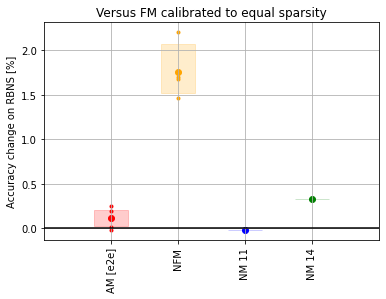

In [22]:
plot_by_model_group(
    np.array(t.to_rbns) * 100,
    list(t.to_rbns.index),
    f"Versus FM calibrated to equal sparsity",
    "Accuracy change on RBNS [%]",
    ax=plt.gca(),
    colors={
        "AM [e2e]": "red",
        "NFM": "orange",
        "NM 11": "blue",
        "NM 14": "green",
    },
)